# 🛡️ Financial Fraud Detection System
This project identifies fraudulent credit card transactions using **Isolation Forest** (unsupervised ML).
It uses **Python**, **MySQL**, and **Power BI** for end-to-end fraud analytics.

In [1]:
# 📦 Install Required Libraries
%pip install pandas numpy scikit-learn matplotlib seaborn mysql-connector-python sqlalchemy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 📁 Load and Preprocess Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("creditcard.csv")

# Normalize Amount and Time
scaler = StandardScaler()
df['norm_amount'] = scaler.fit_transform(df[['Amount']])
df['norm_time'] = scaler.fit_transform(df[['Time']])
df.drop(['Time', 'Amount'], axis=1, inplace=True)

df = df[['norm_time', 'norm_amount'] + [col for col in df.columns if col not in ['Class', 'norm_time', 'norm_amount']] + ['Class']]
df.rename(columns={"Class": "actual_fraud"}, inplace=True)
df.head()

,norm_time,norm_amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,actual_fraud
0,-1.996583,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-1.996583,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.996562,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-1.996562,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.996541,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 📊 Exploratory Data Analysis

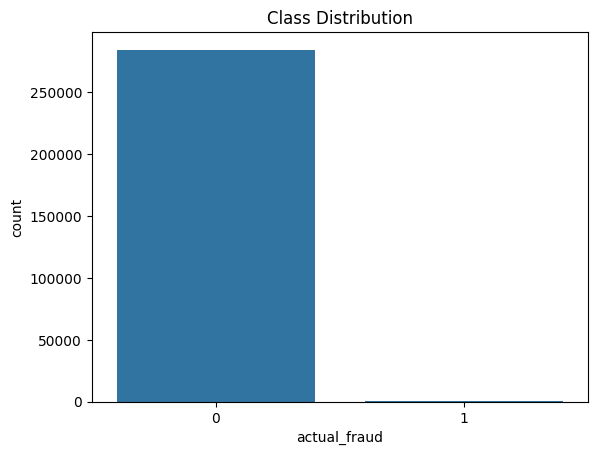

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class imbalance
sns.countplot(x='actual_fraud', data=df)
plt.title("Class Distribution")
plt.show()

## 🤖 Train Isolation Forest Model

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df.drop(['actual_fraud'], axis=1)
y = df['actual_fraud']

clf = IsolationForest(contamination=0.001, random_state=42)
clf.fit(X)

df['anomaly_score'] = clf.decision_function(X)
df['predicted_fraud'] = clf.predict(X)
df['predicted_fraud'] = df['predicted_fraud'].apply(lambda x: 1 if x == -1 else 0)

## 📉 Evaluation Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.38      0.22      0.28       492

    accuracy                           1.00    284807
   macro avg       0.69      0.61      0.64    284807
weighted avg       1.00      1.00      1.00    284807

ROC AUC Score: 0.05077241705888737


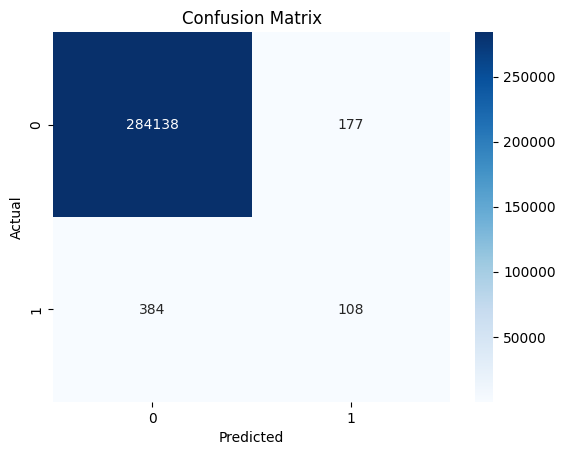

In [5]:
print(classification_report(df['actual_fraud'], df['predicted_fraud']))
print("ROC AUC Score:", roc_auc_score(df['actual_fraud'], df['anomaly_score']))

# Confusion Matrix
cm = confusion_matrix(df['actual_fraud'], df['predicted_fraud'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## 🗃️ Export to MySQL

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler

# 1. Load your dataset (replace path with your dataset path)
df = pd.read_csv("creditcard.csv")

# 2. Normalize relevant columns (Amount, Time)
scaler = StandardScaler()
df['norm_amount'] = scaler.fit_transform(df[['Amount']])
df['norm_time'] = scaler.fit_transform(df[['Time']])
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# 3. Reorder and rename columns as needed
df = df[['norm_time', 'norm_amount'] + [col for col in df.columns if col not in ['norm_time', 'norm_amount', 'Class']] + ['Class']]
df.rename(columns={"Class": "actual_fraud"}, inplace=True)

# 4. Create SQL Alchemy engine with your MySQL credentials
user = "root"
password = "your_password"
host = "localhost"
database = "fraud_detection"

engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")

# 5. Export DataFrame to MySQL
df.to_sql("transactions", con=engine, if_exists="replace", index=False)
print("✅ Data exported to MySQL successfully!")
# 6. Load data back from MySQL to verify
df_loaded = pd.read_sql("SELECT * FROM transactions", con=engine)